### Conor Sayres 
### Astro 507, HW 3

#### 1)
Imports and constants

In [1]:
import numpy
numpy.seterr("ignore")
import matplotlib.pyplot as plt
from scipy.integrate import quad

kb = 1.3806504e-16 # erg per K
h = 6.62606885e-27 # erg per s
c = 2.99792458e10 # cm per s
jy = 10**-23 # erg s^-1 cm^-2 Hz^-1
T_CMB = 2.725 # K

Load CMB data, and convert to specific intensity with frequencies in Hz

In [2]:
data = numpy.loadtxt("firas_monopole_spec_v1.txt")
nu = data[:,0] * c # convert to s^-1
I = data[:,1] * (10**6*jy) # convert to specific intensity
sigmaI = data[:,3] * (10**3*jy) # convert to specific intensity

Code up the nominal blackbody

In [3]:
def blackbody(nu, mu, T):
    # nu is s^-1, frequency
    # mu is erg, chemical potential
    # T is K, temperature
    # returns units of erg s^-1 cm^-2 sr^-1 per frequency
    # specific intensity

    return 2*h*nu**3/c**2/(numpy.exp((h*nu-mu)/(kb*T)) - 1)

Compare the data to the blackbody model.

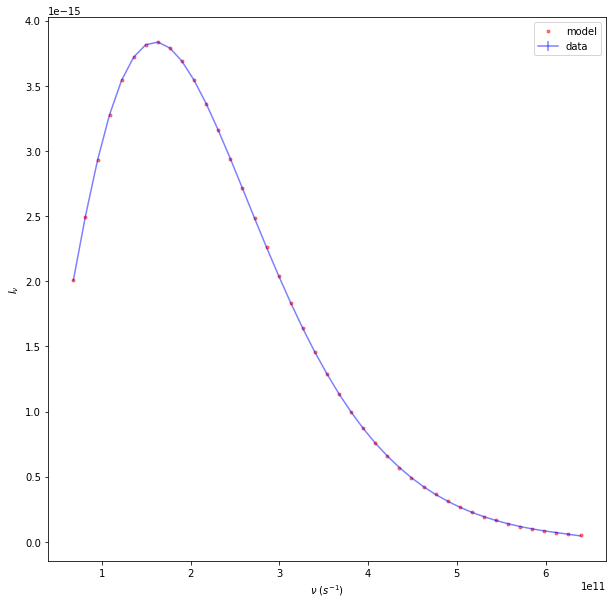

In [4]:
plt.figure(figsize=(10,10))
plt.errorbar(nu, I, yerr=sigmaI, alpha=0.5, color="b", label="data")
modeled = blackbody(nu, 0, T_CMB)
# plt.plot(nu, I, color="b")
plt.plot(nu, modeled, ".r", alpha=0.5, label="model")
plt.xlabel(r"$\nu$ $(s^{-1})$")
plt.ylabel(r"$I_\nu$")
plt.legend();

Agreement is very nice.  Lets plot residuals with corresponding sigmas of data

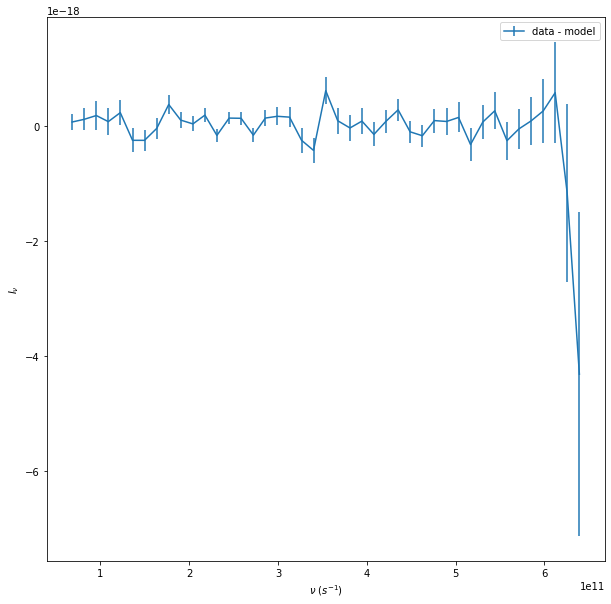

In [5]:
plt.figure(figsize=(10,10))
plt.errorbar(nu, I-modeled, yerr=sigmaI, label="data - model")
plt.xlabel(r"$\nu$ $(s^{-1})$")
plt.ylabel(r"$I_\nu$")
plt.legend();

Vary T and $\mu$.  Temp is varied to betwen $\pm$1e-4 about the CMB temperature of 2.725 K.  $\mu$ is varied about $\pm$(1e-4)($k_BT$) Compute a $\chi^2$ metric for each grid point. 

In [6]:
tPoints = 500
muPoints = 300
Ts = numpy.linspace(T_CMB-1e-4, T_CMB+1e-4, tPoints)
muSet = []
chi2Grid = numpy.zeros((tPoints, muPoints))

for i,T in enumerate(Ts):
    Mus = numpy.linspace(-1e-4, 1e-4, muPoints)*kb*T
    muSet.append(Mus)
    for j,mu in enumerate(Mus):
        chi2 = numpy.sum((I - blackbody(nu, mu, T))**2/sigmaI**2)
        chi2Grid[i,j] = chi2
muSet = numpy.array(muSet)

Bias the grid to the minimum $\chi^2$ found.  Plot the surface with contours corresponding to $\Delta\chi^2 = 1, 2.71, 6.63$.

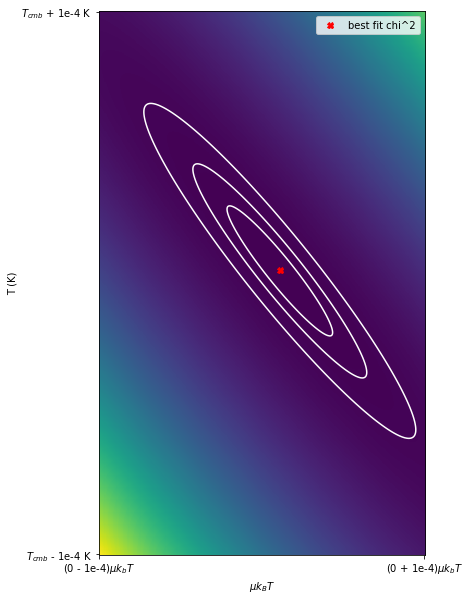

In [7]:
chi2Grid = chi2Grid - numpy.min(chi2Grid)
bestFit = numpy.argwhere(chi2Grid==0).flatten()
# print("best Fit", bestFit)
chi2levels = [1, 2.71, 6.63]

fig = plt.figure(figsize=(10,10))
im = plt.imshow(chi2Grid, origin="lower")
ax = plt.gca()
minChi = numpy.min(chi2Grid)
ax.contour(chi2Grid, levels=chi2levels, colors='w')#, origin='image')#, extent=extent)
plt.xlabel(r"$\mu k_BT$")
plt.ylabel(r"T (K)")
ax.set_xticks([0, 299])
ax.set_yticks([0, 499])
ax.set_xticklabels([r"(0 - 1e-4)$\mu k_b T$", r"(0 + 1e-4)$\mu k_b T$"])
ax.set_yticklabels([r"$T_{cmb}$ - 1e-4 K", r"$T_{cmb}$ + 1e-4 K"])
# fig.colorbar(im)
plt.plot(bestFit[1], bestFit[0], "Xr", label="best fit chi^2")
plt.legend();

Extract the $\mu k_B T$ values from the outermost contour and normalize by $k_B T$, these should be all the values allowed with 99% confidence.  Plot the histogram of the allowed values.

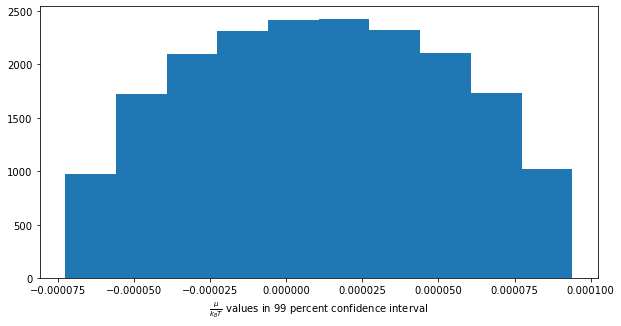

In [8]:
plt.figure(figsize=(10,5))
# extract the mus where chi2 < 6.63
goodMus = [muSet[x][y]/(kb*Ts[x]) for x,y in numpy.argwhere(chi2Grid<6.63)]
plt.hist(goodMus)
plt.xlabel(r"$\frac{\mu}{k_B T}$ values in 99 percent confidence interval");


What is the furthest distance from 0 in the distribution above?

In [9]:
print(numpy.max(numpy.abs(goodMus)))

9.397993311036789e-05


#### 2)
(see handed in)
#### 3)
Code up the constants and conversions required for the problem:

In [10]:
T = 6e6 # temp of star K
pc = 325 # g per cm^3 central density of star
me = 9.10938e-28 # g electron mass
mp = 1.67e-24 # g mass of proton
nh = pc/(mp+0.1*mp*4) # number density of hydrogen
nhe = 0.1*nh # number density of helium
ne = nh + 2*nhe # electron number density
s = 1/2 # electron spin states
lambd = h/(2*numpy.pi*me*kb*T)**(0.5)

Write a function for Fermi-Dirac to be integrated numerically.

In [11]:
def fermiDirac(w, nu, z):
    return w**(nu)/(numpy.exp(w)/z + 1)

#### a)
Estimate the electron fugacity by the Fermi-Dirac function numerical integration and finding where it equals the derived electron density above.

solved for fucacity 5.258443459110612


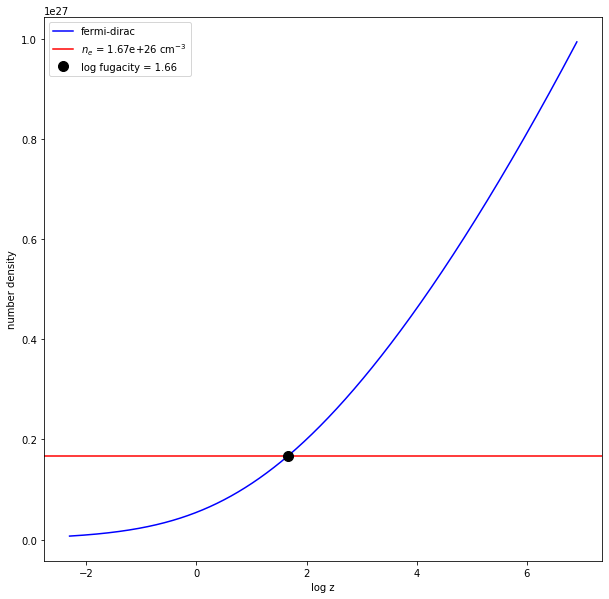

In [12]:
density = []
zs = numpy.logspace(-1,3,100000)
for z in zs:
    fz = quad(fermiDirac, 0, numpy.inf, args=(0.5, z))
    # get density
    _ne = 2*(2*s+1)/(numpy.pi**(1/2)*lambd**3)*fz[0]
    density.append(_ne)
density = numpy.array(density)

# find fugacity at given ne
minInd = numpy.argmin(numpy.abs(density-ne))
bestFugacity = zs[minInd]
print("solved for fucacity", bestFugacity)

plt.figure(figsize=(10,10))
plt.plot(numpy.log(zs), density, 'b', label="fermi-dirac")
plt.axhline(ne, color="r", label=r"$n_e$ = %.2e cm$^{-3}$"%(ne))
plt.plot(numpy.log(bestFugacity), ne, 'ok', markersize=10, label="log fugacity = %.2f"%(numpy.log(bestFugacity)))
plt.xlabel("log z")
plt.ylabel("number density")
plt.legend();

#### b)
Next solve for pressure, given fugacity we determined in part a).

In [13]:
fz = quad(fermiDirac, 0, numpy.inf, args=(1.5, bestFugacity))
pressure = 4*(2*s+1)/(3*numpy.pi**(1/2)*lambd**3)*fz[0]*kb*T
print("pressure %.2e g cm^-1 s^-2"%pressure)

pressure 1.93e+17 g cm^-1 s^-2


#### c)
Are the electrons non-relativistic?  For this lets compute the ratio of the Fermi momentum to $m_e c$:

In [14]:
pf = h*(3*ne/(8*numpy.pi))**(1/3)
print("fermi momentum to me*c: %.2f << 1, so non-relativistic"%(pf/(me*c)))

fermi momentum to me*c: 0.07 << 1, so non-relativistic


#### d)
Show the degeneracy pressure is important.  To do this I'll plot the ratio of the pressure we solved for in b) to the pressure according to the ideal gas law:

In [15]:
pClassical = ne*kb*T
# compare ratio:
print("ratio of classical pressure to degenerate pressure: %.2f"%(pClassical/pressure))

ratio of classical pressure to degenerate pressure: 0.72


...Thats a significant deviation

#### e)
Estimate the mass and radius (in solar units) according the the polytrope relations:

In [16]:
mu_e = pc/(mp*ne)
F = quad(fermiDirac, 0, numpy.inf, args=(0.5, bestFugacity))[0]
A = 0.13 / (mu_e*F)**(2/3)
M = (A**3*pc/8.44)**(1/2)
R = (8.44*M/pc)**(1/3)
print("Mass = %.2f solar masses"%M)
print("Radius = %.2f solar radii"%R)

Mass = 0.12 solar masses
Radius = 0.15 solar radii


...thanks for identifying my initial temperature typo, Eric!